Blog: https://blog.futuresmart.ai/fine-tuning-hugging-face-transformers-model        
YouTube: https://www.youtube.com/watch?v=9he4XKqqzvE


We hereby fine-tune the DistilBERT model for the sentiment analysis task using the following SMS Spam Collection dataset, which has 2 classes: spam and ham.

Dataset Link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

- Install the transformers library using `!pip install transformers -U` and import the required libraries:

In [1]:
#!pip install transformers -U

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

2023-08-27 15:19:10.868842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


- Load the dataset containing toxic comments using `pd.read_csv` and select only the relevant columns:

In [2]:
data=pd.read_csv('spam-utf8.csv', header=0, usecols = ['v1','v2']).rename(columns={'v1':'label','v2':'text'})

data.loc[data['label']=='ham', 'label'] = 0
data.loc[data['label']=='spam', 'label'] = 1

data = data.astype({'label': 'int16'})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int16 
 1   text    5572 non-null   object
dtypes: int16(1), object(1)
memory usage: 54.5+ KB


- Split the dataset into training, validation,and testing sets using `train_test_split` from sklearn. 60% of the data is used for training, 20% for validation, and 20% for testing:

In [4]:
X=list(data['text'])
y=list(data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

- Tokenize the input sequences using the `DistilBertTokenizer` from the transformers library. The `padding=True`, `truncation=True`, and `max_length=512` parameters ensure that all input sequences have the same length.

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

- Create a custom PyTorch dataset using the tokenized input sequences and corresponding labels:

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized, y_test)

In this snippet, we define a custom dataset class `Dataset` that takes the tokenized encodings and labels as input. The `__getitem__` method returns a dictionary of tensors representing each input sample. We create instances of `train_dataset` and `val_dataset` using the tokenized datasets and labels.

- Define a function to compute evaluation metrics (accuracy, recall, precision, and F1-score) for the model:

In [8]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


- Define the training arguments for the Trainer using `TrainingArguments`:

In [9]:
batch_size = 64
logging_steps = len(train_dataset)
# model_name = f"{model_ckpt}-finetuned-spam"


training_args = TrainingArguments(
    output_dir="distilbert-base-uncased",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
#     push_to_hub=True,
    log_level="error"
)



- Define the Trainer using the `Trainer` class from the transformers library, passing in the model, training, and validation datasets, and the evaluation metrics function. Then, we train the model using `trainer.train()`:

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.066558,0.982063,0.951389,0.913333,0.931973
2,No log,0.054658,0.983857,0.958333,0.920000,0.938776


TrainOutput(global_step=106, training_loss=0.13464182727741744, metrics={'train_runtime': 4090.269, 'train_samples_per_second': 1.634, 'train_steps_per_second': 0.026, 'total_flos': 411578277427296.0, 'train_loss': 0.13464182727741744, 'epoch': 2.0})

- Evaluate on the test dataset and create the confusion matrix.

In [11]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') # HD Plots

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(2, 2))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

{'test_loss': 0.04831060394644737, 'test_accuracy': 0.9847533632286996, 'test_precision': 0.9714285714285714, 'test_recall': 0.912751677852349, 'test_f1': 0.9411764705882352, 'test_runtime': 45.8182, 'test_samples_per_second': 24.335, 'test_steps_per_second': 0.393}


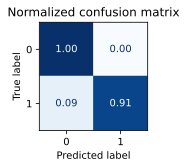

In [12]:
labels = [0,1]

preds_output = trainer.predict(test_dataset)
print(preds_output.metrics)
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_test, labels)

- Evaluate the model and make predictions on new inputs: Here, we define the training arguments and initialize the `Trainer` with the DistilBERT model, training arguments, and the training and validation datasets. We train the model using `trainer.train()` and evaluate its performance on the validation set using `trainer.evaluate()`:

In [ ]:
trainer.evaluate()

In [15]:
text = "That was good point"
inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
print("predictions = ", predictions)
y_preds = np.argmax(predictions)
print("y_preds = ", y_preds)

predictions =  [[0.99351573 0.00648424]]
y_preds =  0


The output has a 0.97 score for a positive label indicating that the text was a positive comment.

We save the fine-tuned model using `trainer.save_model()` to a directory called `bert-base-uncased-finetuned-toxic-comments`. Later, we load the saved model using `DistilBertForSequenceClassification.from_pretrained()` and move it to the GPU:

In [16]:
trainer.save_model('distilbert-base-uncased-finetuned-spam')


We can load the saved model and make predictions on new inputs.

Finally, we provide an example text and tokenize it. We pass the tokenized inputs through the loaded model (`model_2`) to obtain the predicted probabilities using the `softmax` function. The predictions are converted to a numpy array for further processing:

In [18]:
model_2 = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-spam")
model_2.to(device)

text = "send me you bank account at https://give.me.your.money.com"
inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)
outputs = model_2(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
predictions = predictions.cpu().detach().numpy()
print("predictions = ", predictions)
y_preds = np.argmax(predictions)
print("y_preds = ", y_preds)

predictions =  [[0.27196094 0.72803915]]
y_preds =  1


Here we have a 0.80 score for the negative label, indicating that the text represents a negative comment.

This code demonstrates how to fine-tune a pre-trained DistilBERT model on a custom dataset using the Hugging Face Transformers library. The model is trained to classify toxic comments, and evaluation metrics such as accuracy, recall, precision, and F1-score are computed to assess the model's performance. Finally, the trained model is saved and can be loaded later to make predictions on new inputs.